Dataset loaded successfully!
First 5 rows of the dataset:
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  

Dataset Info:
<class 'pandas.core.frame.

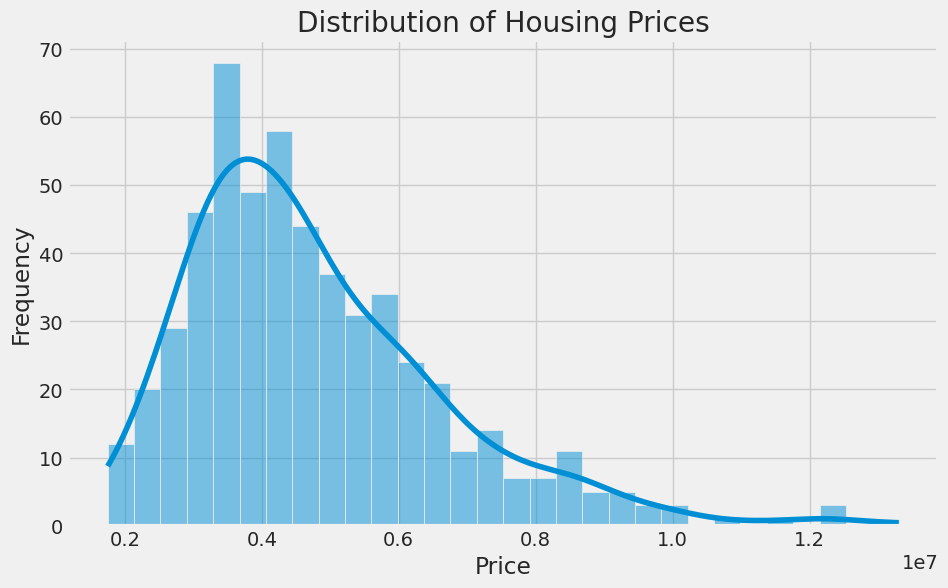

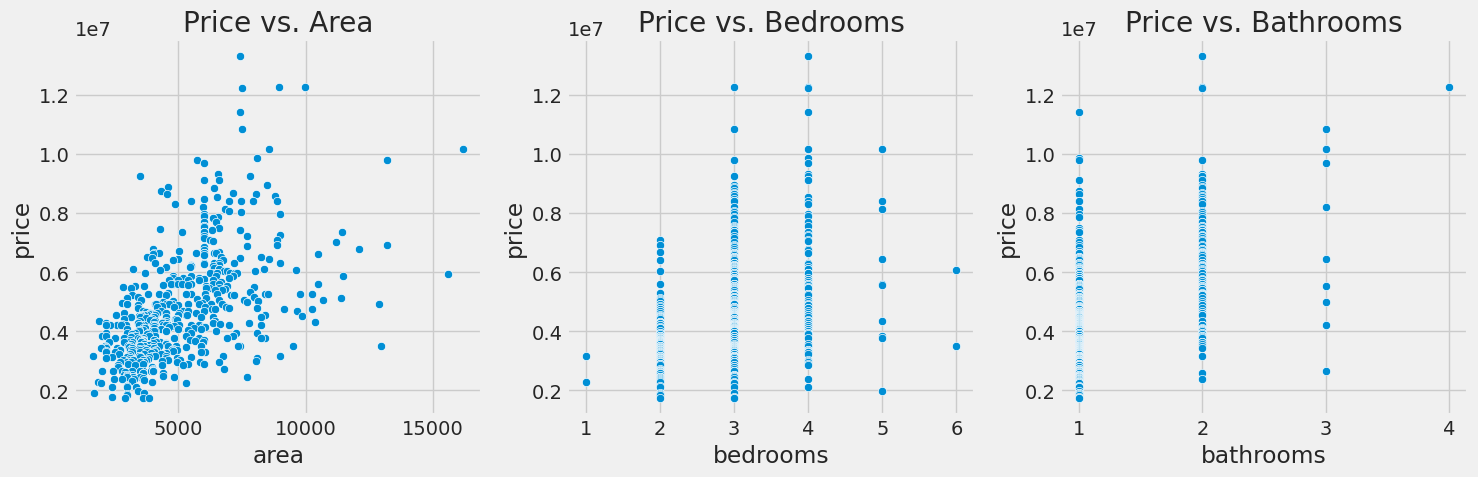


Dataset after converting categorical variables:
      price  area  bedrooms  bathrooms  stories  mainroad  guestroom  \
0  13300000  7420         4          2        3         1          0   
1  12250000  8960         4          4        4         1          0   
2  12250000  9960         3          2        2         1          0   
3  12215000  7500         4          2        2         1          0   
4  11410000  7420         4          1        2         1          1   

   basement  hotwaterheating  airconditioning  parking  prefarea  \
0         0                0                1        2         1   
1         0                0                1        3         0   
2         1                0                0        2         1   
3         1                0                1        3         1   
4         1                0                1        2         0   

   semi-furnished  unfurnished  
0               0            0  
1               0            0  
2         

2025/07/31 17:33:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model training complete.

--- Model Evaluation Metrics ---
Mean Absolute Error (MAE): 1053537.75
Mean Squared Error (MSE): 2075265597440.00
Root Mean Squared Error (RMSE): 1440578.22
R-squared (R²): 0.5894
Logged metrics to MLflow.


2025/07/31 17:33:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged model to MLflow.


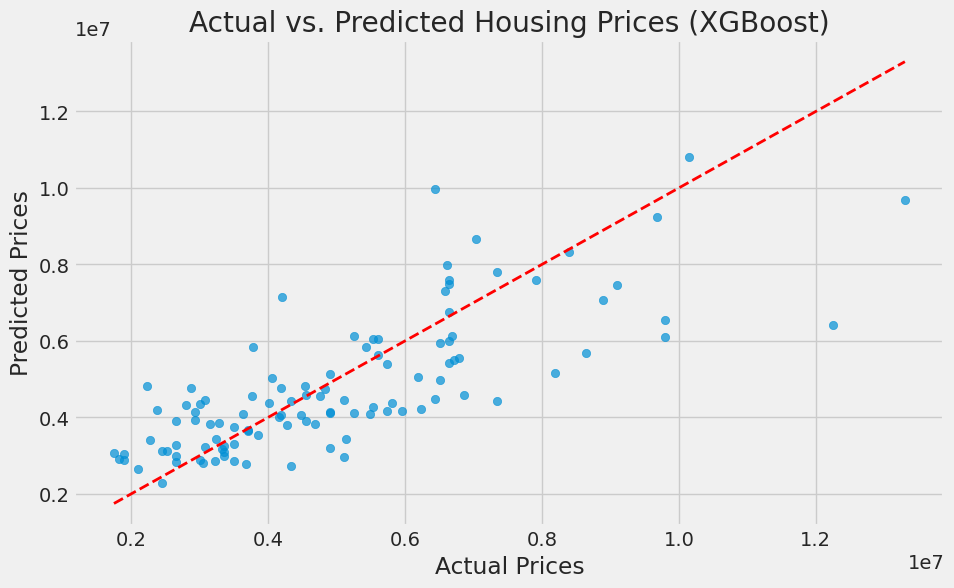

Logged visualization artifact to MLflow: actual_vs_predicted_plot.png


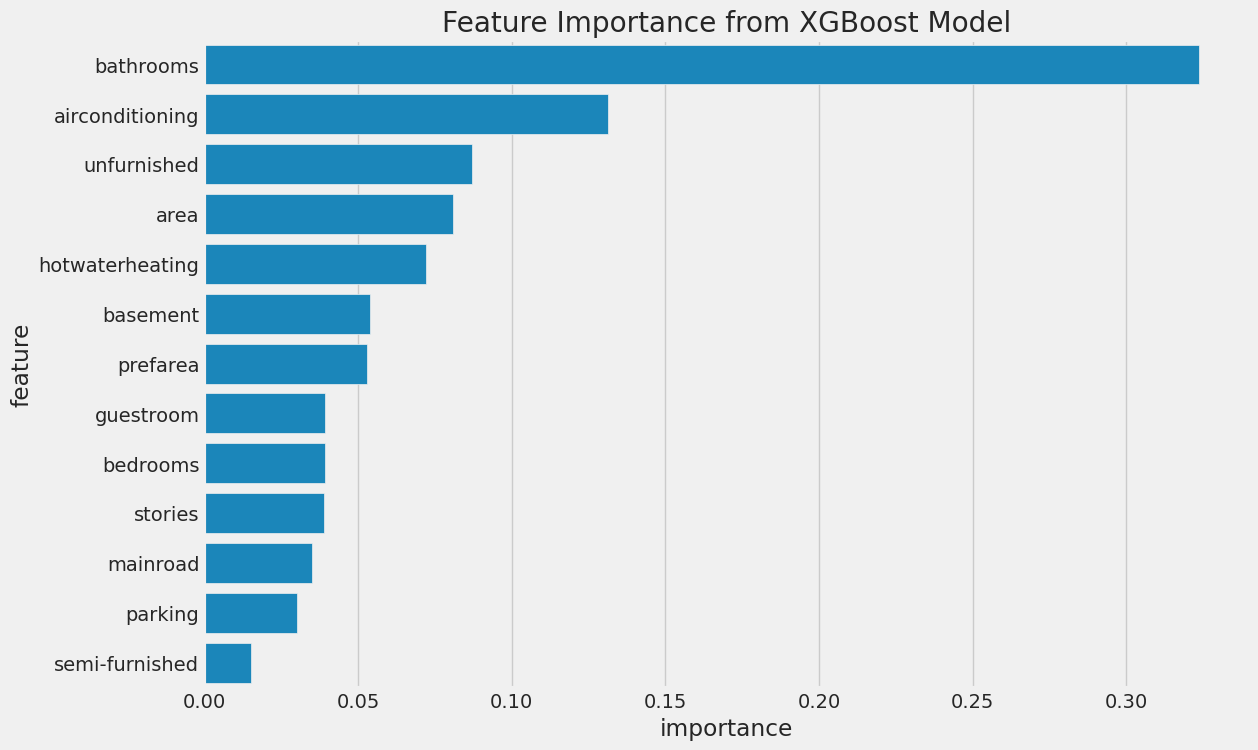

Logged feature importance artifact to MLflow: feature_importance_plot.png

MLflow run completed.
🏃 View run XGBoost_Run at: http://127.0.0.1:5000/#/experiments/750249416814487687/runs/bba394029b2941f4b6aa2e0282ec39da
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/750249416814487687


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import mlflow
import mlflow.sklearn

# Set plot style
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

# --- MLflow Configuration ---
# Set the MLflow tracking URI to your local server
mlflow.set_tracking_uri("http://127.0.0.1:5000")
# Set an experiment name
mlflow.set_experiment("Housing Price Prediction")


# --- 1. Load the Dataset ---
# Load the housing data from the provided CSV file.
try:
    df = pd.read_csv('Housing.csv')
    print("Dataset loaded successfully!")
    print("First 5 rows of the dataset:")
    print(df.head())
except FileNotFoundError:
    print("Error: Housing.csv not found. Please make sure the file is in the correct directory.")
    exit()

# --- 2. Exploratory Data Analysis (EDA) & Preprocessing ---

# Display basic information about the dataset
print("\nDataset Info:")
df.info()

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# --- Data Visualization ---
print("\nGenerating exploratory plots...")

# Plotting the distribution of the target variable 'price'
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True, bins=30)
plt.title('Distribution of Housing Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Visualizing relationships between price and key numerical features
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x='area', y='price', data=df)
plt.title('Price vs. Area')

plt.subplot(1, 3, 2)
sns.scatterplot(x='bedrooms', y='price', data=df)
plt.title('Price vs. Bedrooms')

plt.subplot(1, 3, 3)
sns.scatterplot(x='bathrooms', y='price', data=df)
plt.title('Price vs. Bathrooms')
plt.tight_layout()
plt.show()

# --- Data Preprocessing for Modeling ---

# Convert binary categorical variables ('yes'/'no') to numeric (1/0)
binary_vars = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
df[binary_vars] = df[binary_vars].apply(lambda x: x.map({'yes': 1, 'no': 0}))

# Use one-hot encoding for the 'furnishingstatus' column
furnishing_status = pd.get_dummies(df['furnishingstatus'], drop_first=True, dtype=int)
df = pd.concat([df, furnishing_status], axis=1)
df.drop(['furnishingstatus'], axis=1, inplace=True)

print("\nDataset after converting categorical variables:")
print(df.head())

# --- 3. Train-Test Split ---
# We will split the data into training and testing sets.
# 80% for training, 20% for testing.
test_split_ratio = 0.2
random_state_seed = 42

# Define features (X) and target (y)
X = df.drop('price', axis=1)
y = df['price']
# Get column names right after creating the feature DataFrame 'X'.
X_cols = X.columns

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split_ratio, random_state=random_state_seed)

# --- Feature Scaling ---
# We scale the features to bring them into a similar range.
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"\nData split into training and testing sets.")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


# --- 4. & 5. Model Training, Evaluation, and MLflow Logging ---

# Start an MLflow run
with mlflow.start_run(run_name="XGBoost_Run") as run:
    print("\nStarting MLflow run...")

    # --- Model Hyperparameters ---
    n_estimators = 100
    learning_rate = 0.1
    
    # --- Log Parameters ---
    mlflow.log_param("model_type", "XGBRegressor")
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("random_state_seed", random_state_seed)
    mlflow.log_param("feature_scaling", "MinMaxScaler")
    print("Logged parameters to MLflow.")

    # --- Apply XGBoost Regressor Model ---
    print("\nTraining the XGBoost Regressor model...")
    # Create an XGBoost Regressor model object
    xgb_model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, random_state=random_state_seed)

    # Train the model using the training data
    xgb_model.fit(X_train, y_train)
    print("Model training complete.")

    # Make predictions on the test set
    y_pred = xgb_model.predict(X_test)

    # --- Model Evaluation ---
    print("\n--- Model Evaluation Metrics ---")
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(y_test, y_pred)

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R²): {r2:.4f}")

    # --- Log Metrics to MLflow ---
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2_score", r2)
    print("Logged metrics to MLflow.")

    # --- Log the Model to MLflow ---
    mlflow.sklearn.log_model(xgb_model, "xgboost-model")
    print("Logged model to MLflow.")

    # --- Visualize and Log Artifacts ---
    # Create and log the Actual vs. Predicted plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', linewidth=2)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title('Actual vs. Predicted Housing Prices (XGBoost)')
    
    plot_path_pred = "actual_vs_predicted_plot.png"
    plt.savefig(plot_path_pred)
    plt.show()
    
    mlflow.log_artifact(plot_path_pred)
    print(f"Logged visualization artifact to MLflow: {plot_path_pred}")

    # Create and log the Feature Importance plot
    importances = xgb_model.feature_importances_
    feature_importance_df = pd.DataFrame({'feature': X_cols, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title('Feature Importance from XGBoost Model')
    
    plot_path_feat = "feature_importance_plot.png"
    plt.savefig(plot_path_feat)
    plt.show()

    mlflow.log_artifact(plot_path_feat)
    print(f"Logged feature importance artifact to MLflow: {plot_path_feat}")

    print("\nMLflow run completed.")